In [ ]:
# import os
# import random
# import itertools
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoTokenizer, LongformerModel, LongformerConfig, LongformerTokenizer

# def set_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True

# class TextDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length
    
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, idx):
#         text1 = self.texts.iloc[idx]['source_content']
#         text2 = self.texts.iloc[idx]['suspicious_content']
        
#         encoding1 = self.tokenizer.encode_plus(
#             text1,
#             add_special_tokens=True,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors='pt'
#         )

#         encoding2 = self.tokenizer.encode_plus(
#             text2,
#             add_special_tokens=True,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors='pt'
#         )

        
#         return {
#             'input_ids_1': encoding1['input_ids'].squeeze(),
#             'attention_mask_1': encoding1['attention_mask'].squeeze(),
#             'input_ids_2': encoding2['input_ids'].squeeze(),
#             'attention_mask_2': encoding2['attention_mask'].squeeze(),
#             'labels': torch.tensor(self.labels[idx], dtype=torch.long)
#         }


# class SiameseLongformer(nn.Module): 
#     def __init__(self, model_name, num_labels, max_length):
#         super(SiameseLongformer, self).__init__()
#         self.config = LongformerConfig.from_pretrained(model_name)
#         self.config.output_hidden_states = False
#         self.config.max_position_embeddings = 16384
#         self.config.attention_mode == 'sliding_chunks'
#         self.config.attention_window = [256] * self.config.num_hidden_layers
#         self.config.gradient_checkpointing=True
        
#         # Single encoder for both inputs (shared weights)
#         self.longformer = LongformerModel.from_pretrained(model_name, config=self.config)
        
#         # Concatenate embeddings, hence input size is doubled
#         self.dropout = nn.Dropout(0.2)
#         self.dense = nn.Linear(self.config.hidden_size * 2, 64)  # Updated input size
#         self.classifier = nn.Linear(64, num_labels)
#         self.relu = nn.ReLU()
#         # self.softmax = nn.Softmax(dim=1)
    
#     def encode(self, input_ids, attention_mask):
#         outputs = self.longformer(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#         )
#         # Global average pooling
#         return outputs.last_hidden_state.mean(dim=1)
    
#     def forward(self, input_ids_1, attention_mask_1,
#                 input_ids_2, attention_mask_2):
        
#         # Use the same encoder for both inputs
#         embedding1 = self.encode(input_ids_1, attention_mask_1)
#         embedding2 = self.encode(input_ids_2, attention_mask_2)
        
#         # Concatenate embeddings
#         concatenated = torch.cat((embedding1, embedding2), dim=1)
        
#         # Classification layers
#         x = self.dense(concatenated)
#         x = self.relu(x)
#         x = self.dropout(x)
#         logits = self.classifier(x)
#         # probabilities = self.softmax(logits)
        
#         return logits
    
# def train_model(model, train_loader, val_loader, criterion, optimizer, schedular,num_epochs, device, map_label=None):
#     best_val_loss = float('inf')
    
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         all_train_preds = []
#         all_train_labels = []
        
#         # Training loop
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
#             input_ids_1 = batch['input_ids_1'].to(device)
#             attention_mask_1 = batch['attention_mask_1'].to(device)
#             input_ids_2 = batch['input_ids_2'].to(device)
#             attention_mask_2 = batch['attention_mask_2'].to(device)
#             labels = batch['labels'].to(device)
            
#             optimizer.zero_grad()
            
#             outputs = model(
#                 input_ids_1, attention_mask_1,
#                 input_ids_2, attention_mask_2
#             )
            
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             train_loss += loss.item()
            
#             # Collect predictions and labels

#             _, predicted = torch.max(torch.softmax(outputs, dim=1), 1)
#             all_train_preds.extend(predicted.cpu().numpy())
#             all_train_labels.extend(labels.cpu().numpy())
#         schedular.step()
        
#         # Validation loop
#         model.eval()
#         val_loss = 0
#         all_val_preds = []
#         all_val_labels = []
        
#         with torch.no_grad():
#             for batch in val_loader:
#                 input_ids_1 = batch['input_ids_1'].to(device)
#                 attention_mask_1 = batch['attention_mask_1'].to(device)
#                 input_ids_2 = batch['input_ids_2'].to(device)
#                 attention_mask_2 = batch['attention_mask_2'].to(device)
#                 labels = batch['labels'].to(device)
                
#                 outputs = model(
#                     input_ids_1, attention_mask_1,
#                     input_ids_2, attention_mask_2
#                 )
                
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
                
#                 # Collect predictions and labels

#                 _, predicted = torch.max(torch.softmax(outputs, dim=1), 1)
#                 # _, predicted = torch.max(outputs, 1)
#                 all_val_preds.extend(predicted.cpu().numpy())
#                 all_val_labels.extend(labels.cpu().numpy())
         
#         # Print current epoch's metrics
#         print(f'\nEpoch {epoch + 1}:')
#         print(f'Training Loss: {train_loss/len(train_loader):.4f}')
#         print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        
#         if map_label:
#             # Training Metrics
#             train_report = classification_report(
#                 [map_label[i] for i in all_train_labels],
#                 [map_label[i] for i in all_train_preds],
#                 output_dict=True
#             )
#             print("\nTraining Metrics:")
#             print(f"Accuracy: {train_report['accuracy']:.4f}")
#             print(f"Macro F1-Score: {train_report['macro avg']['f1-score']:.4f}")
#             print(f"Weighted F1-Score: {train_report['weighted avg']['f1-score']:.4f}")
            
#             # Validation Metrics
#             val_report = classification_report(
#                 [map_label[i] for i in all_val_labels],
#                 [map_label[i] for i in all_val_preds],
#                 output_dict=True
#             )
#             print("\nValidation Metrics:")
#             print(f"Accuracy: {val_report['accuracy']:.4f}")
#             print(f"Macro F1-Score: {val_report['macro avg']['f1-score']:.4f}")
#             print(f"Weighted F1-Score: {val_report['weighted avg']['f1-score']:.4f}")
    
#         # Save best model
#         if val_loss/len(val_loader) < best_val_loss:
#             best_val_loss = val_loss/len(val_loader)
#             torch.save(model.state_dict(), 'best_model.pt')
    
#     return all_val_preds, all_val_labels

# def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=25)
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
#     plt.yticks(tick_marks, classes, fontsize=15)
    
#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black", fontsize=14)
    
#     plt.ylabel('True label', fontsize=20)
#     plt.xlabel('Predicted label', fontsize=20)

# def main():
#     # Set constants
#     MAX_SEQUENCE_LENGTH = 14000
#     MODEL_NAME = "longformer-encdec-large-16384"
#     BATCH_SIZE = 5
#     NUM_EPOCHS = 10
#     LEARNING_RATE = 2e-5
#     DEVICE = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
#     #
#     # Set seed for reproducibility
#     set_seed(33)
    
#     # Load and preprocess data
#     df = pd.read_csv('FinalDatasetBalanced.csv')
#     df['plagiarism_type'] = df['plagiarism_type'].factorize()[0]
#     map_label = dict(enumerate(df['plagiarism_type'].factorize()[1]))
    
#     X_train, X_test, y_train, y_test = train_test_split(
#         df[['source_content', 'suspicious_content']], 
#         df['plagiarism_type'].values,
#         random_state=33,
#         test_size=0.3
#     )
    
#     # Initialize tokenizer
#     tokenizer = LongformerTokenizer.from_pretrained(MODEL_NAME) # or try the autotokeinzer tokenizer ##########################to be noticed#################################333
    
#     # Create datasets
#     train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_SEQUENCE_LENGTH)
#     test_dataset = TextDataset(X_test, y_test, tokenizer, MAX_SEQUENCE_LENGTH)
    
#     # Create dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
#     # Initialize model
#     # model = DualLongformer(MODEL_NAME, len(map_label), MAX_SEQUENCE_LENGTH)
#     model = SiameseLongformer(MODEL_NAME, len(map_label), MAX_SEQUENCE_LENGTH)
#     model = model.to(DEVICE)
    
#     # Initialize loss and optimizer
#     from sklearn.utils.class_weight import compute_class_weight

#     # class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
#     class_weights = compute_class_weight(
#     class_weight="balanced", 
#     classes=np.unique(y_train), 
#     y=y_train)
#     class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

#     # class_weights = torch.tensor([0.1305, 0.1552, 0.1556, 0.5587]).to(DEVICE)
#     criterion = nn.CrossEntropyLoss(weight=class_weights)
#     # criterion = nn.CrossEntropyLoss()


#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-4)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

    
#     # Train model
#     # train_model(model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)
#     all_preds, all_labels = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler,NUM_EPOCHS, DEVICE, map_label)

    
#     # Plot confusion matrix
#     cnf_matrix = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(7,7))
#     plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
#     plt.show()

# if __name__ == "__main__":
#     main()

/home/msi/miniconda3/envs/triallong/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Epoch 1/10: 100%|██████████| 425/425 [04:14<00:00,  1.67it/s]



Epoch 1:
Training Loss: 0.8793
Validation Loss: 0.3922

Training Metrics:
Accuracy: 0.6918
Macro F1-Score: 0.5816
Weighted F1-Score: 0.6805

Validation Metrics:
Accuracy: 0.9025
Macro F1-Score: 0.7079
Weighted F1-Score: 0.8815


Epoch 2/10: 100%|██████████| 425/425 [04:16<00:00,  1.66it/s]



Epoch 2:
Training Loss: 0.3876
Validation Loss: 0.3309

Training Metrics:
Accuracy: 0.8880
Macro F1-Score: 0.7727
Weighted F1-Score: 0.8799

Validation Metrics:
Accuracy: 0.9093
Macro F1-Score: 0.7412
Weighted F1-Score: 0.8945


Epoch 3/10: 100%|██████████| 425/425 [04:13<00:00,  1.68it/s]



Epoch 3:
Training Loss: 0.3002
Validation Loss: 0.2895

Training Metrics:
Accuracy: 0.9104
Macro F1-Score: 0.8297
Weighted F1-Score: 0.9094

Validation Metrics:
Accuracy: 0.9135
Macro F1-Score: 0.8128
Weighted F1-Score: 0.9139


Epoch 4/10: 100%|██████████| 425/425 [04:12<00:00,  1.68it/s]



Epoch 4:
Training Loss: 0.2271
Validation Loss: 0.3298

Training Metrics:
Accuracy: 0.9358
Macro F1-Score: 0.8871
Weighted F1-Score: 0.9375

Validation Metrics:
Accuracy: 0.9203
Macro F1-Score: 0.7971
Weighted F1-Score: 0.9141


Epoch 5/10: 100%|██████████| 425/425 [04:09<00:00,  1.70it/s]



Epoch 5:
Training Loss: 0.1663
Validation Loss: 0.4254

Training Metrics:
Accuracy: 0.9617
Macro F1-Score: 0.9315
Weighted F1-Score: 0.9623

Validation Metrics:
Accuracy: 0.9258
Macro F1-Score: 0.7539
Weighted F1-Score: 0.9062


Epoch 6/10: 100%|██████████| 425/425 [04:07<00:00,  1.72it/s]



Epoch 6:
Training Loss: 0.1329
Validation Loss: 0.3209

Training Metrics:
Accuracy: 0.9682
Macro F1-Score: 0.9421
Weighted F1-Score: 0.9686

Validation Metrics:
Accuracy: 0.9368
Macro F1-Score: 0.8255
Weighted F1-Score: 0.9287


Epoch 7/10: 100%|██████████| 425/425 [04:13<00:00,  1.68it/s]



Epoch 7:
Training Loss: 0.0828
Validation Loss: 0.4069

Training Metrics:
Accuracy: 0.9841
Macro F1-Score: 0.9711
Weighted F1-Score: 0.9843

Validation Metrics:
Accuracy: 0.9354
Macro F1-Score: 0.8152
Weighted F1-Score: 0.9255


Epoch 8/10: 100%|██████████| 425/425 [04:14<00:00,  1.67it/s]



Epoch 8:
Training Loss: 0.0602
Validation Loss: 0.4431

Training Metrics:
Accuracy: 0.9864
Macro F1-Score: 0.9750
Weighted F1-Score: 0.9866

Validation Metrics:
Accuracy: 0.9299
Macro F1-Score: 0.8010
Weighted F1-Score: 0.9185


Epoch 9/10: 100%|██████████| 425/425 [04:13<00:00,  1.68it/s]



Epoch 9:
Training Loss: 0.0545
Validation Loss: 0.4922

Training Metrics:
Accuracy: 0.9894
Macro F1-Score: 0.9818
Weighted F1-Score: 0.9895

Validation Metrics:
Accuracy: 0.9368
Macro F1-Score: 0.8026
Weighted F1-Score: 0.9231


Epoch 10/10: 100%|██████████| 425/425 [04:14<00:00,  1.67it/s]



Epoch 10:
Training Loss: 0.0371
Validation Loss: 0.4975

Training Metrics:
Accuracy: 0.9935
Macro F1-Score: 0.9889
Weighted F1-Score: 0.9936

Validation Metrics:
Accuracy: 0.9423
Macro F1-Score: 0.8201
Weighted F1-Score: 0.9297


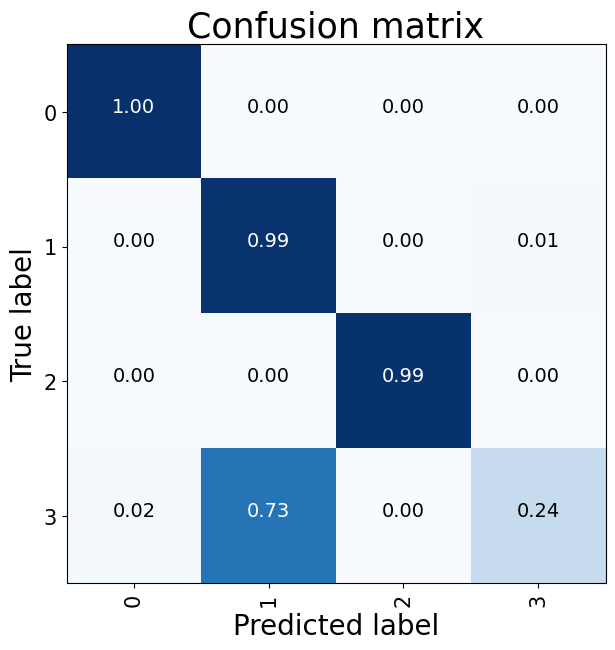

In [2]:
import os
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, LongformerModel, LongformerConfig, LongformerTokenizer

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text1 = self.texts.iloc[idx]['source_content']
        text2 = self.texts.iloc[idx]['suspicious_content']
        
        encoding1 = self.tokenizer.encode_plus(
            text1,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        encoding2 = self.tokenizer.encode_plus(
            text2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        
        return {
            'input_ids_1': encoding1['input_ids'].squeeze(),
            'attention_mask_1': encoding1['attention_mask'].squeeze(),
            'input_ids_2': encoding2['input_ids'].squeeze(),
            'attention_mask_2': encoding2['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

from transformers import T5Tokenizer, T5EncoderModel

class DualAraT5(nn.Module):
    def __init__(self, model_name, num_labels):
        super(DualAraT5, self).__init__()
        
        # Load AraT5 encoder
        self.encoder1 = T5EncoderModel.from_pretrained(model_name)
        # self.encoder2 = T5EncoderModel.from_pretrained(model_name)
        
        # Define classification head
        hidden_size = self.encoder1.config.d_model  # Hidden size of AraT5
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(hidden_size * 2, 64)
        self.classifier = nn.Linear(64, num_labels)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids_1, attention_mask_1,
                input_ids_2, attention_mask_2):
        
        # Pass inputs through the two encoders
        outputs1 = self.encoder1(input_ids=input_ids_1, attention_mask=attention_mask_1)
        outputs2 = self.encoder1(input_ids=input_ids_2, attention_mask=attention_mask_2)
        
        # Pool the output (mean pooling)
        pooled_output1 = outputs1.last_hidden_state.mean(dim=1)
        pooled_output2 = outputs2.last_hidden_state.mean(dim=1)
        
        # Concatenate embeddings
        concatenated = torch.cat((pooled_output1, pooled_output2), dim=1)
        
        # Classification layers
        x = self.dense(concatenated)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.classifier(x)
        
        return logits
    
def train_model(model, train_loader, val_loader, criterion, optimizer, schedular,num_epochs, device, map_label=None):
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        
        # Training loop
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids_1 = batch['input_ids_1'].to(device)
            attention_mask_1 = batch['attention_mask_1'].to(device)
            input_ids_2 = batch['input_ids_2'].to(device)
            attention_mask_2 = batch['attention_mask_2'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(
                input_ids_1, attention_mask_1,
                input_ids_2, attention_mask_2
            )
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Collect predictions and labels

            _, predicted = torch.max(torch.softmax(outputs, dim=1), 1)
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
        schedular.step()
        
        # Validation loop
        model.eval()
        val_loss = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids_1 = batch['input_ids_1'].to(device)
                attention_mask_1 = batch['attention_mask_1'].to(device)
                input_ids_2 = batch['input_ids_2'].to(device)
                attention_mask_2 = batch['attention_mask_2'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids_1, attention_mask_1,
                    input_ids_2, attention_mask_2
                )
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Collect predictions and labels

                _, predicted = torch.max(torch.softmax(outputs, dim=1), 1)
                # _, predicted = torch.max(outputs, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
         
        # Print current epoch's metrics
        print(f'\nEpoch {epoch + 1}:')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        
        if map_label:
            # Training Metrics
            train_report = classification_report(
                [map_label[i] for i in all_train_labels],
                [map_label[i] for i in all_train_preds],
                output_dict=True
            )
            print("\nTraining Metrics:")
            print(f"Accuracy: {train_report['accuracy']:.4f}")
            print(f"Macro F1-Score: {train_report['macro avg']['f1-score']:.4f}")
            print(f"Weighted F1-Score: {train_report['weighted avg']['f1-score']:.4f}")
            
            # Validation Metrics
            val_report = classification_report(
                [map_label[i] for i in all_val_labels],
                [map_label[i] for i in all_val_preds],
                output_dict=True
            )
            print("\nValidation Metrics:")
            print(f"Accuracy: {val_report['accuracy']:.4f}")
            print(f"Macro F1-Score: {val_report['macro avg']['f1-score']:.4f}")
            print(f"Weighted F1-Score: {val_report['weighted avg']['f1-score']:.4f}")
    
        # Save best model
        if val_loss/len(val_loader) < best_val_loss:
            best_val_loss = val_loss/len(val_loader)
            torch.save(model.state_dict(), 'best_model.pt')
    
    return all_val_preds, all_val_labels

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)
    
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

def main():
    # Set constants
    MAX_SEQUENCE_LENGTH = 1024  # Maximum sequence length for AraT5
    MODEL_NAME = "UBC-NLP/AraT5v2-base-1024"  # AraT5 model
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    LEARNING_RATE = 2e-5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set seed for reproducibility
    set_seed(33)
    
    # Load and preprocess data
    df = pd.read_csv('ayhaga2.csv')
    df['plagiarism_type'] = df['plagiarism_type'].factorize()[0]
    map_label = dict(enumerate(df['plagiarism_type'].factorize()[1]))
    
    X_train, X_test, y_train, y_test = train_test_split(
        df[['source_content', 'suspicious_content']], 
        df['plagiarism_type'].values,
        random_state=33,
        test_size=0.3
    )
    
    # Initialize tokenizer
    tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
    
    # Create datasets
    train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_SEQUENCE_LENGTH)
    test_dataset = TextDataset(X_test, y_test, tokenizer, MAX_SEQUENCE_LENGTH)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model
    model = DualAraT5(MODEL_NAME, len(map_label))
    model = model.to(DEVICE)
    
    # # Initialize loss and optimizer
    # from sklearn.utils.class_weight import compute_class_weight
    # class_weights = compute_class_weight(
    #     class_weight="balanced", 
    #     classes=np.unique(y_train), 
    #     y=y_train)
    # class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

    class_weights = torch.tensor([0.1305, 0.1552, 0.1556, 0.5587]).to(DEVICE)


    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

    # Train model
    all_preds, all_labels = train_model(
        model, train_loader, test_loader, 
        criterion, optimizer, scheduler, NUM_EPOCHS, DEVICE, map_label
    )

    # Plot confusion matrix
    cnf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 7))
    plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
    plt.show()

if __name__ == "__main__":
    main()
